In [1]:
import aisdb
from aisdb import DBQuery
from aisdb.database.dbconn import PostgresDBConn
from datetime import datetime, timedelta
from aisdb.discretize.h3 import Discretizer
import random
import matplotlib.pyplot as plt
import contextily as cx
import itertools
import pandas as pd
import geopandas as gpd

In [ ]:
# >>> PostgreSQL Information <<<
db_user='<>'            # DB User
db_dbname='<>'         # DB Schema
db_password='<>'    # DB Password
db_hostaddr='127.0.0.1'    # DB Host address

dbconn = PostgresDBConn(
    port=5555,             # PostgreSQL port
    user=db_user,          # PostgreSQL username
    dbname=db_dbname,      # PostgreSQL database
    host=db_hostaddr,      # PostgreSQL address
    password=db_password,  # PostgreSQL password
)

In [17]:
xmin, ymin, xmax, ymax = -70, 45, -58, 53
gulf_bbox = [xmin, xmax, ymin, ymax]
start_time = datetime(2023, 8, 1)
end_time = datetime(2023, 8, 2)

qry = DBQuery(
    dbconn=dbconn,
    start=start_time, end=end_time,
    xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax,
    callback=aisdb.database.sqlfcn_callbacks.in_time_bbox_validmmsi
)

ais_tracks = []
rowgen = qry.gen_qry()

In [18]:
descritizer = Discretizer(resolution=6)

# Creating discretizer object and describe based on its resolution

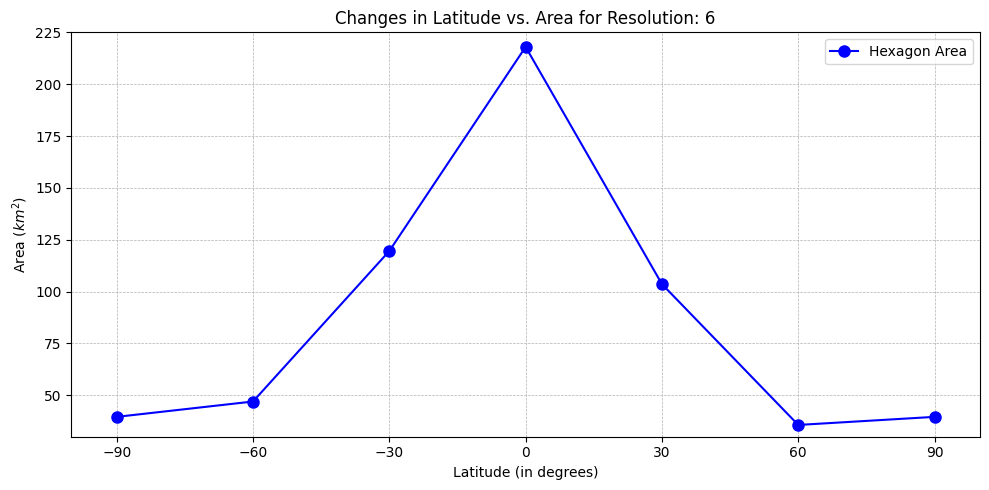


[Changes in Latitude vs. Area for Resolution: 6]
Latitude -90 (deg): Hexagon area = 39.57 (km2)
Latitude -60 (deg): Hexagon area = 46.98 (km2)
Latitude -30 (deg): Hexagon area = 119.55 (km2)
Latitude 0 (deg): Hexagon area = 217.97 (km2)
Latitude 30 (deg): Hexagon area = 103.59 (km2)
Latitude 60 (deg): Hexagon area = 35.68 (km2)
Latitude 90 (deg): Hexagon area = 39.57 (km2)

[Changes in Resolution vs. Area - [0-15]]
Resolution 0 has 1281.256011000 (km) per edge.
Resolution 1 has 483.056839100 (km) per edge.
Resolution 2 has 182.512956500 (km) per edge.
Resolution 3 has 68.979221790 (km) per edge.
Resolution 4 has 26.071759680 (km) per edge.
Resolution 5 has 9.854090990 (km) per edge.
Resolution 6 has 3.724532667 (km) per edge.
Resolution 7 has 1.406475763 (km) per edge.
Resolution 8 has 0.531414010 (km) per edge.
Resolution 9 has 0.200786148 (km) per edge.
Resolution 10 has 0.075863783 (km) per edge.
Resolution 11 has 0.028663897 (km) per edge.
Resolution 12 has 0.010830188 (km) per ed

In [4]:
descritizer = Discretizer(resolution=6)
descritizer.describe()

# Using Tracks for Discretization

In [19]:
tracks = aisdb.track_gen.TrackGen(rowgen, decimate=True)
tracks_segment = aisdb.track_gen.split_timedelta(tracks,
                                                     timedelta(weeks=4))
tracks_with_indexes = descritizer.yield_tracks_discretized_by_indexes(tracks)

In [20]:
tracks_copy1,tracks_copy2,tracks_copy3,tracks_copy4 = itertools.tee(tracks_with_indexes, 4)

for track in tracks_copy1:
    print(f"H3 Index for lat {track['lat'][0]}, lon {track['lon'][0]}: {track['h3_index'][0]}")
    break

H3 Index for lat 50.003334045410156, lon -66.76000213623047: 860e4d31fffffff


# Vizualization for Discretization

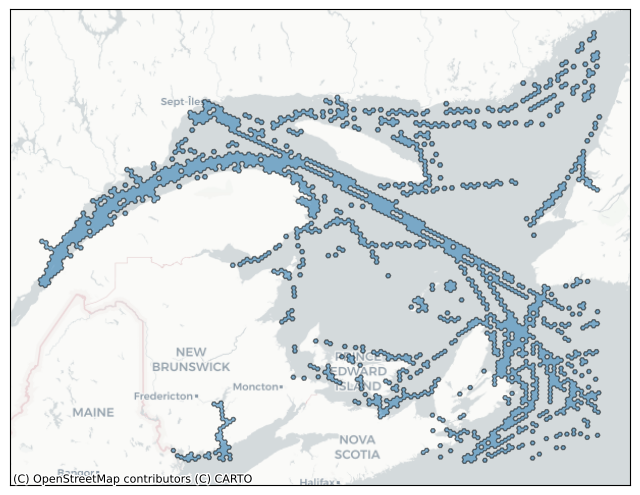

In [21]:
descritizer.plot_discretized_tracks(tracks = tracks_copy4 ,ax=None) # shapefile_path is optional

## Discretization using a pre-processed shapefile

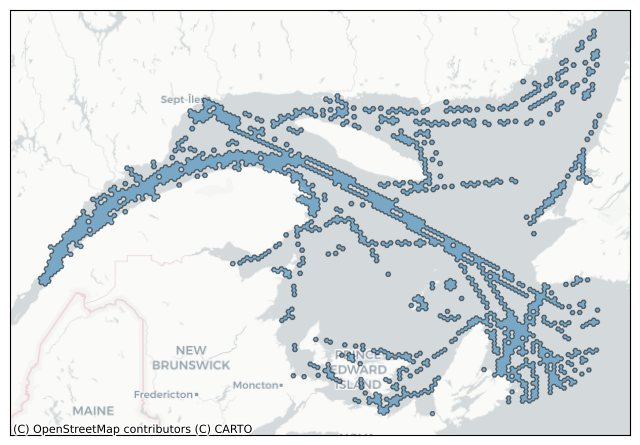

In [ ]:
descritizer.plot_discretized_tracks(tracks = tracks_copy2, shapefile_path = 'outputs/new_filtered_hexagons.shp',ax=None) # shapefile_path is optional

# Extending the usage of discretization vizualization

In [23]:
# Color Tracks function (assigns colors)
def color_tracks2(tracks):
    colors = {}
    for track in tracks:
        mmsi = track.get('mmsi')
        if mmsi not in colors:
            # Assign a random color to this MMSI if not already assigned
            colors[mmsi] = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        track['color'] = colors[mmsi]  # Set the color for the current track
        yield track
        
def plot_tracks_with_hex_grids(tracks):
    tracks_copy1, tracks_copy2 = itertools.tee(tracks, 2)

    # Color the tracks
    colored_tracks = list(color_tracks2(tracks_copy1))

    # Convert tracks to GeoDataFrame for CRS transformation
    track_data = []
    min_lon, max_lon = float('inf'), float('-inf')
    min_lat, max_lat = float('inf'), float('-inf')

    for track in colored_tracks:
        # Update the bounding box
        min_lon = min(min_lon, *track['lon'])
        max_lon = max(max_lon, *track['lon'])
        min_lat = min(min_lat, *track['lat'])
        max_lat = max(max_lat, *track['lat'])

        # Creating a GeoDataFrame directly with the correct geometry
        geometry = gpd.GeoSeries(gpd.points_from_xy(track['lon'], track['lat']))
        gdf = gpd.GeoDataFrame({
            'mmsi': [track['mmsi']] * len(track['lat']),
            'geometry': geometry
        }, crs='EPSG:4326')
        track_data.append(gdf)

    # Merge all track GeoDataFrames and reproject to EPSG:3857 (Web Mercator)
    gdf_tracks = pd.concat(track_data, ignore_index=True)
    gdf_tracks = gdf_tracks.to_crs(epsg=3857)

    # Plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot vessel tracks with different colors
    for track in colored_tracks:
        # Transform coordinates to EPSG:3857 for each track
        transformed_coords = gpd.GeoSeries(gpd.points_from_xy(track['lon'], track['lat'])).set_crs('EPSG:4326').to_crs(epsg=3857)
        
        # Plot the entire track as a line (not individual points)
        ax.plot(transformed_coords.x, transformed_coords.y, color=track['color'], linewidth=2)

    # Plot hex grids (discretized tracks)
    descritizer.plot_discretized_tracks(tracks=tracks_copy2,shapefile_path = 'outputs/new_filtered_hexagons.shp', ax=ax)

    # Add CartoDB basemap (EPSG:3857)
    cx.add_basemap(ax, crs='EPSG:3857', source=cx.providers.CartoDB.Positron)

    # Set the limits to zoom in on the tracks
    # Convert min/max lat/lon to EPSG:3857 for accurate plotting limits
    min_lon, min_lat = gpd.GeoSeries(gpd.points_from_xy([min_lon], [min_lat])).set_crs('EPSG:4326').to_crs(epsg=3857).total_bounds[:2]
    max_lon, max_lat = gpd.GeoSeries(gpd.points_from_xy([max_lon], [max_lat])).set_crs('EPSG:4326').to_crs(epsg=3857).total_bounds[:2]

    ax.set_xlim(min_lon, max_lon)
    ax.set_ylim(min_lat, max_lat)

    ax.legend(loc='upper right')
    ax.set_title('Vessel Tracks with Hex Grids and Interpolated Path')
    plt.show()

/tmp/ipykernel_3609677/2329022746.py:67: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


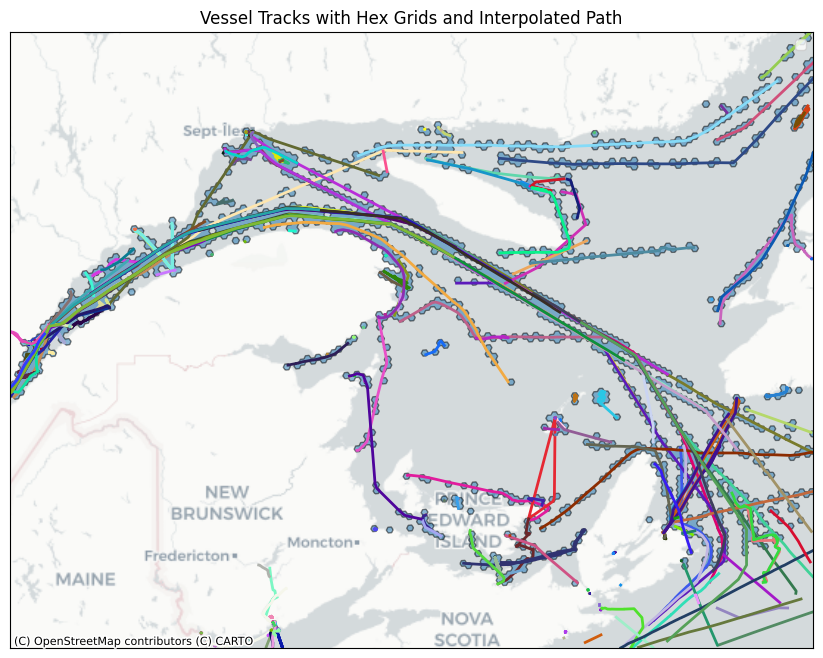

In [24]:
plot_tracks_with_hex_grids(tracks_copy3)